# Prediction Error Filter (PEF) в сейсморазведке: Деконволюция

**Prediction Error Filter (PEF)** — это один из ключевых инструментов обработки сейсмических данных.  
Его суть заключается в линейном предсказании: сигнал моделируется как линейная комбинация своих прошлых значений.  
Фильтр подбирается так, чтобы минимизировать предсказанную часть и оставить **ошибку предсказания** (prediction error).  

PEF используется в разных задачах сейсморазведки:  
- для **деконволюции** (удаления волновой формы и получения отражений),  
- для **подавления шума** (удаления непредсказуемой компоненты),  
- для **интерполяции и восстановления пропусков** в данных,  
- для анализа спектральных свойств сигнала.  

В этом ноутбуке мы рассмотрим пошаговый пример применения PEF для деконволюции синтетической сейсмотрассы.


### 1. Импульс Берлаге

Импульс Берлаге — минимально-фазовый импульс, который используется в сейсморазведке для моделирования морских данных. Его вид:

$$
w(t) = t^n \, e^{-\alpha t} \cos(2\pi f t + \varphi)
$$

где:
* $n$ — показатель степени (формирует начальный фронт);
* $\alpha$ — коэффициент затухания;
* $f$ — доминирующая частота;
* $\varphi$ — фазовый сдвиг.


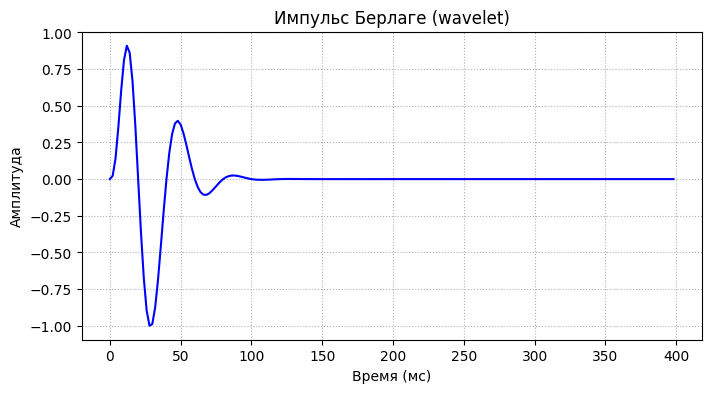

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def berlage(duration, dt, f, n=2, alpha=100, phi=-np.pi/2):
    t = np.arange(0, duration, dt)
    waveform = t**n * np.exp(-alpha * t) * np.cos(2 * np.pi * f * t + phi)
    return waveform, t

# параметры импульса
dt_ms = 2.0
dt = dt_ms / 1000.0
wavelet, t_wave = berlage(0.4, dt, f=25, n=2, alpha=100, phi=-np.pi/2)
wavelet /= np.max(np.abs(wavelet))

plt.figure(figsize=(8,4))
plt.plot(t_wave*1000, wavelet, 'b')
plt.title("Импульс Берлаге (wavelet)")
plt.xlabel("Время (мс)")
plt.ylabel("Амплитуда")
plt.grid(True, linestyle=":")
plt.show()

### 2. Создание коэффициентов отражения (reflectivity) для моделирования сейсмической трассы

Reflectivity моделируется как набор разреженных спайков с различной амплитудой. Получаем одномерную модель среды


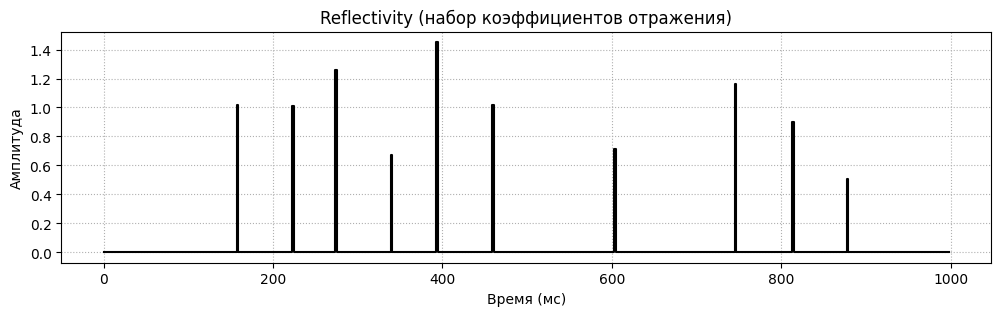

In [2]:
def create_reflectivity_uniform(duration, dt, n_spikes,
    amp_min=0.5, amp_max=1.5,
    min_interval_ms=50,
    edge_buffer_ms=50,
    max_attempts=10000
):
    n_samples = int(duration / dt)
    dt_ms_local = dt * 1000
    min_interval_samp = int(np.ceil(min_interval_ms / dt_ms_local))
    edge_buffer_samp = int(np.ceil(edge_buffer_ms / dt_ms_local))
    min_valid = edge_buffer_samp
    max_valid = n_samples - edge_buffer_samp
    reflectivity = np.zeros(n_samples)
    indices = []
    attempts = 0
    while len(indices) < n_spikes and attempts < max_attempts:
        cand = np.random.randint(min_valid, max_valid)
        if all(abs(cand - idx) >= min_interval_samp for idx in indices):
            indices.append(cand)
        attempts += 1
    indices = np.array(sorted(indices))
    amps = np.random.uniform(amp_min, amp_max, size=len(indices))
    reflectivity[indices] = amps
    return reflectivity, indices, amps

duration = 1.0
t = np.arange(0, duration, dt)
t_ms = t * 1000

reflectivity, spike_indices, spike_amps = create_reflectivity_uniform(
    duration=duration, dt=dt, n_spikes=10,
    amp_min=0.5, amp_max=1.5,
    min_interval_ms=50, edge_buffer_ms=50
)

plt.figure(figsize=(12,3))
plt.plot(t_ms, reflectivity, 'k', drawstyle="steps-mid")
plt.title("Reflectivity (набор коэффициентов отражения)")
plt.xlabel("Время (мс)")
plt.ylabel("Амплитуда")
plt.grid(True, linestyle=":")
plt.show()

### 3. Свёртка reflectivity с импульсом  

Получаем синтетическую трассу с помощью свёртки импульса с одномерной моделью среды, заданной коэффициентами отражения.


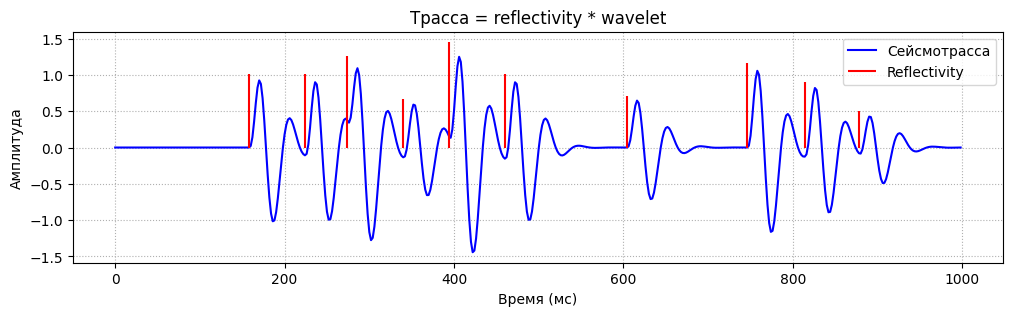

In [3]:
from scipy.signal import convolve

trace = convolve(reflectivity, wavelet, mode='full')[:len(reflectivity)]

plt.figure(figsize=(12,3))
plt.plot(t_ms, trace, 'b', label="Сейсмотрасса")
plt.vlines(t_ms[spike_indices], 0, spike_amps, color='r', label="Reflectivity")
plt.title("Трасса = reflectivity * wavelet")
plt.xlabel("Время (мс)")
plt.ylabel("Амплитуда")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()

### 4. Автокорреляция трассы  

Тут мы претворимся, что не знаем изначальный импульс источника, как почти всегда в сейсмике и происходит, и выполним так называемую "слепую деконволюцию". Нам позволит это сделать автокорреляция - свёртка трассы со своей отраженной копией. 

Ключевая идея заключается в следующем: если отражательная способность (reflectivity) близка к белому шуму (то есть её значения статистически независимы и равномерно распределены во времени), то её автокорреляция приближается к дельта-функции. Поскольку сейсмотрасса представляет собой свёртку импульса с reflectivity, её автокорреляция будет приближённо равна автокорреляции самого импульса. Это позволяет нам оценить характеристики импульса без априорного знания его формы 

$$R(\tau) = \sum_t x(t) x(t+\tau)$$


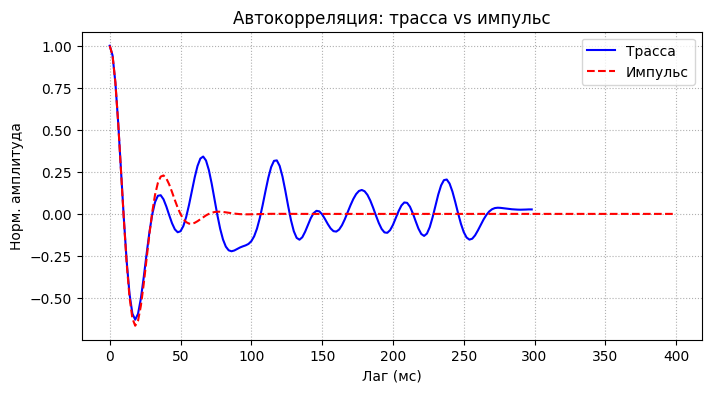

In [4]:
from scipy.signal import correlate

def autocorr(x):
    result = correlate(x, x, mode='full')
    result = result[result.size // 2:]
    return result / result[0] if result[0] != 0 else result

# автокорреляции импульса и трассы
autocorr_wavelet = autocorr(wavelet)
autocorr_trace = autocorr(trace)

lag_max_ms = 300
lags_ms = np.arange(0, lag_max_ms, dt_ms)

plt.figure(figsize=(8,4))
plt.plot(lags_ms, autocorr_trace[:len(lags_ms)], 'b', label="Трасса")
plt.plot(np.arange(len(autocorr_wavelet))*dt_ms, autocorr_wavelet, 'r--', label="Импульс")
plt.title("Автокорреляция: трасса vs импульс")
plt.xlabel("Лаг (мс)")
plt.ylabel("Норм. амплитуда")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()

### 5. Деконволюция через Prediction Error Filter (PEF)  

***Prediction Error Filter (PEF)*** — это линейный фильтр, который подавляет предсказуемую часть сигнала (в нашем случае — сейсмический волновой пакет) и выделяет его непредсказуемую компоненту, то есть отражательную способность (reflectivity), которая в идеале представляет собой последовательность импульсов («спайков»).

PEF лежит в основе предсказывающей деконволюции или спайкинг-деконволюции (как частного случая предсказывающей). Эта методика предполагает, что reflectivity ведёт себя как белый шум, а сейсмический импульс — как коррелированный (предсказуемый) процесс. Цель фильтра — «обратить» этот процесс: сделать выход как можно более импульсным.

Формально PEF проектируется из уравнения Винера–Хопфа, которое минимизирует среднеквадратичную ошибку предсказания:  
$$R \, h = d$$

где  
- \(R\) — матрица Тёплица из автокорреляции,  
- \(h\) — искомый фильтр,  
- \(d\) — единичный вектор с лагом (prediction lag).  


In [5]:
from scipy.linalg import toeplitz

def design_pef(signal, operator_len, white_noise_percent=1.0, pred_lag=1):
    r = autocorr(signal)[:operator_len]
    d = np.zeros(operator_len)
    d[pred_lag] = 1.0
    R = toeplitz(r)
    eps = (white_noise_percent / 100.0) * np.trace(R) / operator_len
    pef = np.linalg.solve(R + eps * np.eye(operator_len), d)
    return pef

def apply_pef_with_padding(signal, pef, dt_ms, pad_ms=200):
    pad_samples = int(np.ceil(pad_ms / dt_ms))
    signal_padded = np.pad(signal, pad_samples, mode='symmetric')
    deconv_padded = convolve(signal_padded, pef, mode='full')
    deconv = deconv_padded[pad_samples : pad_samples + len(signal)]
    return deconv

# проектирование фильтра
operator_len_ms = 30
operator_len = int(np.ceil(operator_len_ms / dt_ms))
white_noise_percent = 0.1
pef = design_pef(trace, operator_len, white_noise_percent=white_noise_percent, pred_lag=0)

# применение
deconvolved = apply_pef_with_padding(trace, pef, dt_ms, pad_ms=200)
deconvolved = deconvolved/np.max(np.abs(deconvolved))

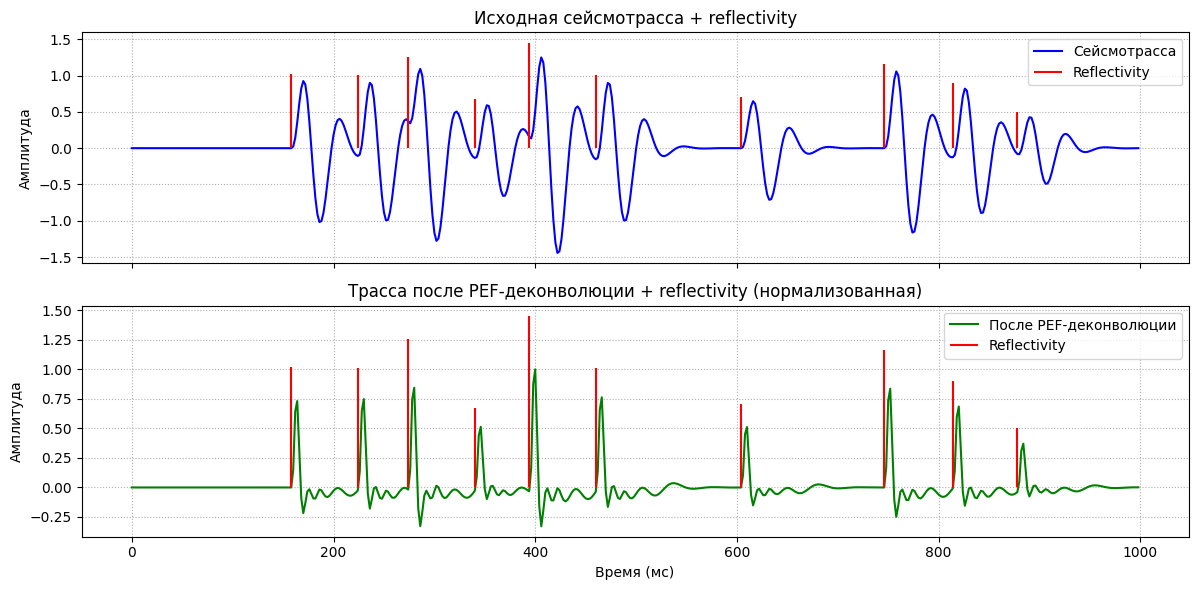

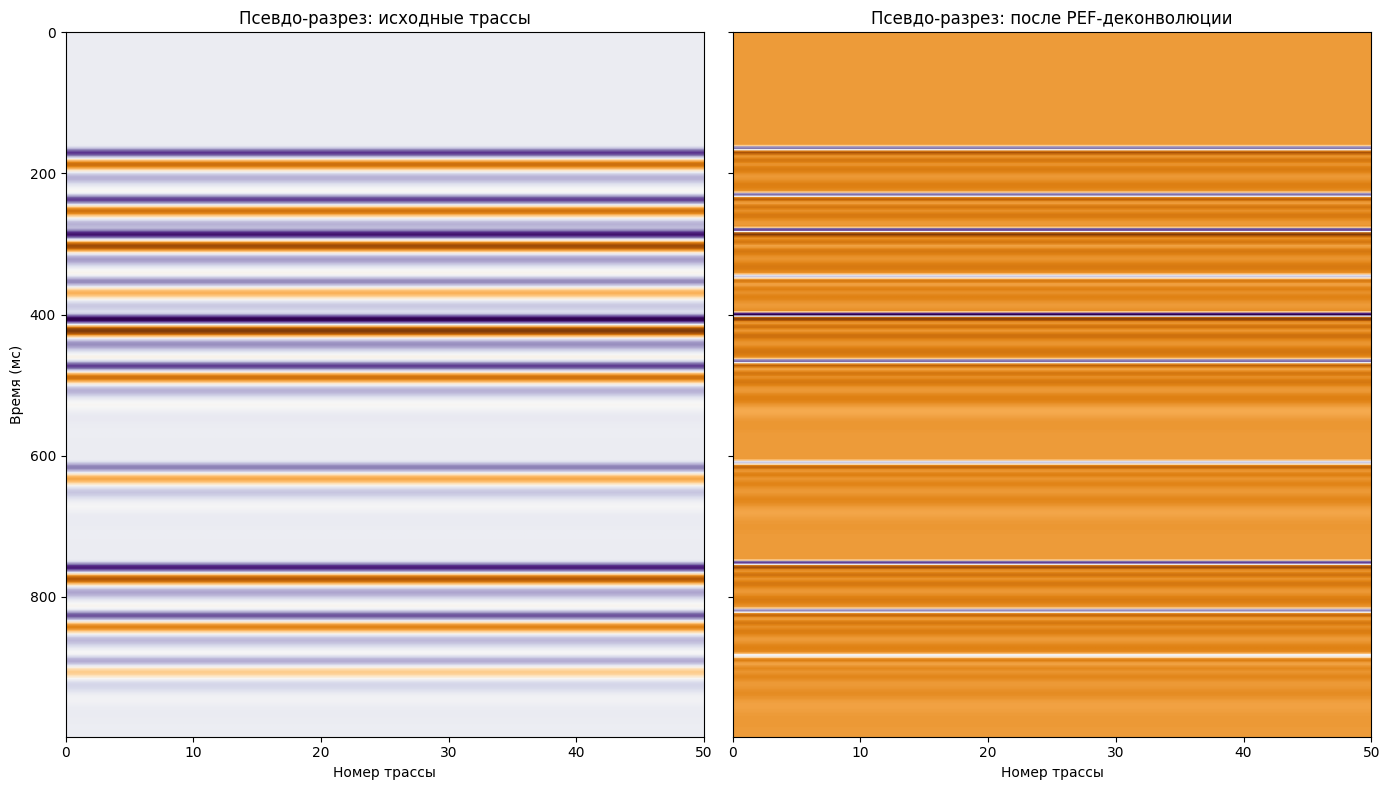

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Первый график: исходная сейсмотрасса
ax1.plot(t_ms, trace, 'b', label="Сейсмотрасса")
ax1.vlines(t_ms[spike_indices], 0, spike_amps, color='r', label="Reflectivity")
ax1.set_title("Исходная сейсмотрасса + reflectivity")
ax1.set_ylabel("Амплитуда")
ax1.legend()
ax1.grid(True, linestyle=":")

# Второй график: после PEF-деконволюции
ax2.plot(t_ms, deconvolved, 'g', label="После PEF-деконволюции")
ax2.vlines(t_ms[spike_indices], 0, spike_amps, color='r', label="Reflectivity")
ax2.set_title("Трасса после PEF-деконволюции + reflectivity (нормализованная)")
ax2.set_xlabel("Время (мс)")
ax2.set_ylabel("Амплитуда")
ax2.legend()
ax2.grid(True, linestyle=":")

plt.tight_layout()
plt.show()

# Создаём псевдо-разрезы: 50 одинаковых трасс
n_traces = 50
section_original = np.tile(trace, (n_traces, 1)).T          # shape: (len(trace), 50)
section_deconv = np.tile(deconvolved, (n_traces, 1)).T      # shape: (len(deconvolved), 50)

# Настройка отображения: определяем временные границы для оси Y
extent = [0, n_traces, t_ms[-1], t_ms[0]]  # [left, right, bottom, top] → время сверху вниз

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

# Левый разрез: оригинальные трассы
im1 = ax1.imshow(section_original, cmap='PuOr', aspect='auto', extent=extent)
ax1.set_title("Псевдо-разрез: исходные трассы")
ax1.set_xlabel("Номер трассы")
ax1.set_ylabel("Время (мс)")

# Правый разрез: после PEF-деконволюции
im2 = ax2.imshow(section_deconv, cmap='PuOr', aspect='auto', extent=extent)
ax2.set_title("Псевдо-разрез: после PEF-деконволюции")
ax2.set_xlabel("Номер трассы")
# ylabel не дублируем, так как sharey=True


plt.tight_layout()
plt.show()

Как видим, после деконволюции форма импульсного отклика приблизиласть к дельта-функции. Можно ещё поиграться с параметрами длины фильтра и белого шума. Кроме того, имеет смысл применить bandpass filter после деконволюции.

### 6. Автокорреляция после деконволюции  

Сравним автокорреляцию до и после деконволюции. После PEF автокорреляция должна быть ближе к δ-функции.


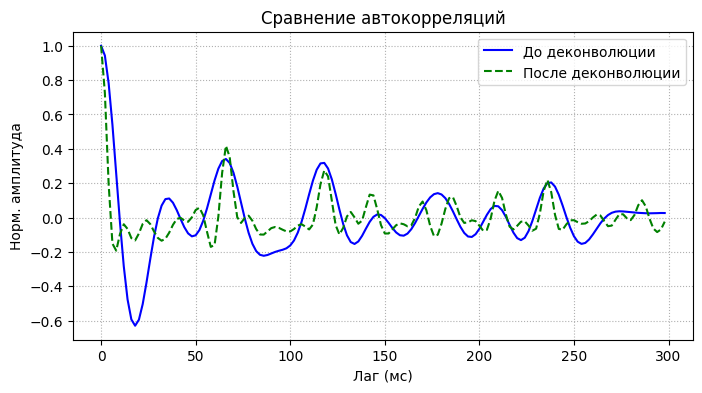

In [7]:
autocorr_noisy = autocorr(trace)
autocorr_deconv = autocorr(deconvolved)

plt.figure(figsize=(8,4))
plt.plot(lags_ms, autocorr_noisy[:len(lags_ms)], 'b', label="До деконволюции")
plt.plot(lags_ms, autocorr_deconv[:len(lags_ms)], 'g--', label="После деконволюции")
plt.title("Сравнение автокорреляций")
plt.xlabel("Лаг (мс)")
plt.ylabel("Норм. амплитуда")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()

### 7. Сравнение спектров до и после деконволюции  

Ещё один способ оценить эффективность деконволюции — сравнить спектры сигналов.  
После применения PEF спектр должен стать более выровненным (белым), без сильных провалов.


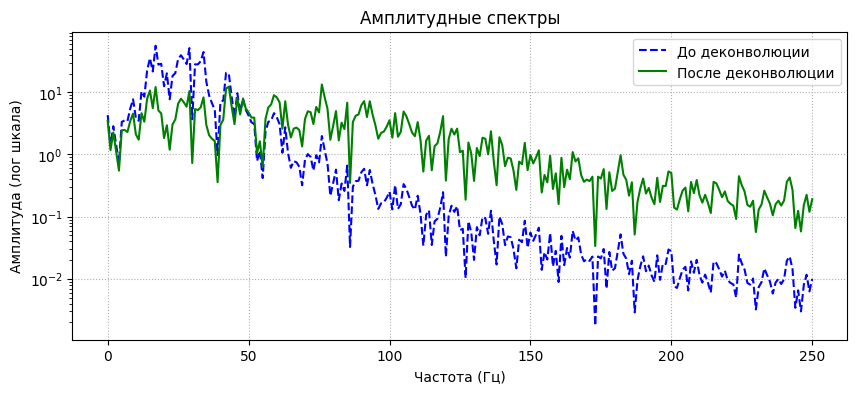

In [8]:
from numpy.fft import rfft, rfftfreq

freqs = rfftfreq(len(trace), d=dt)
spec_noisy = np.abs(rfft(trace))
spec_deconv = np.abs(rfft(deconvolved))

plt.figure(figsize=(10,4))
plt.semilogy(freqs, spec_noisy, 'b--', label="До деконволюции")
plt.semilogy(freqs, spec_deconv, 'g', label="После деконволюции")
plt.title("Амплитудные спектры")
plt.xlabel("Частота (Гц)")
plt.ylabel("Амплитуда (лог шкала)")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()